### Implementation of the `RnnlmGen` class

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from chapter_6.rnnlm import Rnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

### Use the `RnnlmGen` class to generate text

In [2]:
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
#model.load_params('../chapter_6/Rnnlm.pkl')

In [3]:
# set the 'start' word and 'skip' words
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

In [4]:
# text generation
word_ids = model.generate(start_id, skip_ids, sample_size=20)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you five-year rocky peters succession perestroika phase sometimes reclaim builds jacobs deliveries side richter volunteer subordinates immediately esso enhance preferences


In [8]:
model.load_params('../chapter_6/Rnnlm.pkl')

# text generation
word_ids = model.generate(start_id, skip_ids, sample_size=50)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you own is like work argues yesterday by one buffer against credit suisse a prisoner group based on a reporter james coalition.
 conception curbing he was a piece of evidence we need to grant the central committee not even related to mr. jackson 's actual assistant laws for having


### Use the `BetterRnnlmGen` class to generate text

In [9]:
import sys
sys.path.append('..')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('../chapter_6/BetterRnnlm.pkl')

In [10]:
# set the start character and skip character
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# generate text
word_ids = model.generate(start_id, skip_ids, sample_size=20)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)

you have information their own assets raised.
 that 's senator florio nor he has sought the summit to present


In [11]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids, sample_size=10)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
the meaning of life is.
 the most sister do readers know what it


### Addition dataset

In [17]:
from dataset import sequence

In [18]:
(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [32]:
print([id_to_char[i] for i in x_train[0]])
print([id_to_char[i] for i in t_train[0]])

['7', '1', '+', '1', '1', '8', ' ']
['_', '1', '8', '9', ' ']


In [33]:
print([id_to_char[i] for i in x_test[0]])
print([id_to_char[i] for i in t_test[0]])

['7', '7', '+', '8', '5', ' ', ' ']
['_', '1', '6', '2', ' ']


### Evaluation of `Seq2seq`

In [1]:
import sys
sys.path.append('..')
import numpy as np

import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read the dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [3]:
# set hyper-parameters
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

In [5]:
# generate seq2seq model/optimizer/trainer
model = Seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.44
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.05
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.87
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.80
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.77
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.76
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.73
| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.73
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.71
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.70
| epoch 1 |  iter 221 / 351 | time 4[s] | loss 1.69
| epoch 1 |  iter 241 / 351 | time 4[s] | loss 1.67
| epoch 1 |  iter 261 / 351 | time 5[s] | loss 1.65
| epoch 1 |  iter 281 / 351 | time 5[s] | loss 1.62
| epoch 1 |  iter 301 / 351 | time 6[s] | loss 1.61
| epoch 1 |  iter 321 / 351 | time 6[s] | loss 1.60
| epoch 1 |  iter 341 / 351 | time 6[s] | loss 1.58
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1456
---
Q 582+84 
T 66

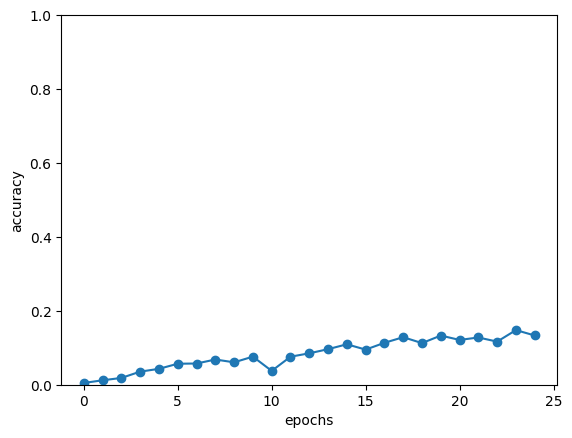

In [6]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, \
                                    id_to_char, verbose, is_reverse=False)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# plot
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

In [4]:
# generate peeky seq2seq model
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.59
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.40
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.07
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.86
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.80
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.77
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.75
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.74
| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.72
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.70
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.69
| epoch 1 |  iter 221 / 351 | time 4[s] | loss 1.67
| epoch 1 |  iter 241 / 351 | time 4[s] | loss 1.67
| epoch 1 |  iter 261 / 351 | time 5[s] | loss 1.63
| epoch 1 |  iter 281 / 351 | time 5[s] | loss 1.62
| epoch 1 |  iter 301 / 351 | time 5[s] | loss 1.59
| epoch 1 |  iter 321 / 351 | time 6[s] | loss 1.58
| epoch 1 |  iter 341 / 351 | time 6[s] | loss 1.56
Q 77+85  
T 162 
☒ 87  
---
Q 975+164
T 1139
☒ 1277
---
Q 582+84 
T 66

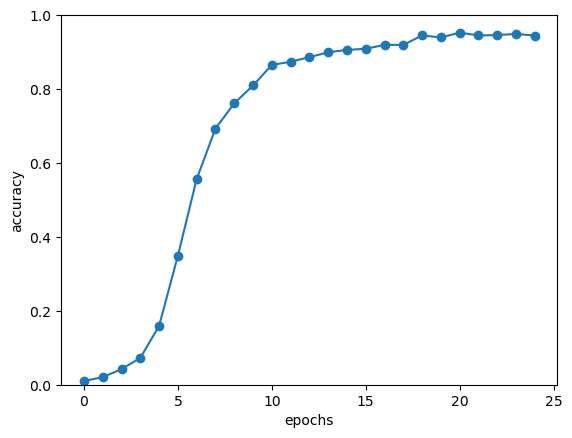

In [5]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, \
                                    id_to_char, verbose, is_reverse=False)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# plot
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()